# **Navigate E-commerce through Predictive Churn Analysis and Customer Segmentation**
***

Expected Outcomes:
* Churn Prediction Model: Identify customers likely to churn and provide actionable retention strategies.
* Customer Segmentation: Detailed customer segments to guide personalized marketing efforts.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import Libraries

In [ ]:
pip install pandas xgboost seaborn scikit-learn imbalanced-learn matplotlib

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, mean_absolute_error, r2_score
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
# Ignore warnings
warnings.filterwarnings('ignore')


## Import Datasets

Dataset source:
https://www.kaggle.com/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis/data?select=ecommerce_customer_data_custom_ratios.csv

In [ ]:
# load datasets
df_ecommerce = pd.read_csv('/content/drive/MyDrive/Belajar/DS Dibimbing.id/Shofi - Progress Script Final Project/ecommerce_customer_data_large.csv')
df_ecommerce

In [ ]:
file_path = 'D:\Shofi\Final\ecommerce_customer_data_large.csv'
df_ecommerce = pd.read_csv(file_path)
df_ecommerce.sample(8)

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
118295,19679,2023-04-04 12:51:23,Home,482,2,3402,Cash,60,1.0,Eric Benjamin,60,Male,0
83937,25199,2020-07-06 18:47:53,Clothing,143,2,1916,PayPal,19,NaN,Tammy Carter,19,Male,0
28783,4186,2021-08-14 22:32:44,Home,187,4,2719,Credit Card,25,0.0,Ann Mullen,25,Male,0
212739,35023,2020-02-08 12:59:08,Books,127,2,4871,PayPal,48,1.0,Kelly Campbell,48,Male,1
222320,32914,2021-04-17 14:54:43,Electronics,92,4,4031,Cash,61,NaN,Darlene Marshall,61,Female,0
157953,10682,2020-10-18 07:53:49,Home,104,5,4784,Credit Card,51,0.0,Samuel Quinn,51,Male,1
210463,14602,2023-05-23 07:20:27,Books,150,3,535,Cash,46,1.0,Nathan Miller,46,Male,0
184944,13038,2022-07-08 19:41:13,Books,419,5,4913,Credit Card,33,NaN,Joseph Johnson,33,Male,0


## 1.  Data Undersanding
### Dataset Desricption

1. Customer ID: A unique identifier for each customer.
2. Purchase Date: The date of each purchase made by the customer.
3. Product Category: The category or type of the purchased product.
4. Product Price: The price of the purchased product.
5. Quantity: The quantity of the product purchased.
6. Total Purchase Amount: The total amount spent by the customer in each transaction.
7. Payment Method: The method of payment used by the customer (e.g., credit card, PayPal).
8. Customer Age: The age of the customer.
9. Returns: Whether the customer returned any products from the order (binary: 0 for no return, 1 for return).
10. Customer Name: The name of the customer.
11. Age: The age of the customer.
12. Gender: The gender of the customer.
13. Churn: A binary column indicating whether the customer has churned (0 for retained, 1 for churned).

In [ ]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


In [ ]:
df_ecommerce["Churn"].value_counts()

Churn
0    199870
1     50130
Name: count, dtype: int64

This dataset have unbalanced target.

## 2. Data Preparation

###  a. Split Data (Train & Test)

Data split is done at the biginning, the goal is to avoid data leakage.
> source: https://towardsdatascience.com/two-rookie-mistakes-i-made-in-machine-learning-improper-data-splitting-and-data-leakage-3e33a99560ea

In [ ]:
X = df_ecommerce.copy()
# Splitting to avoid data leakage (train : test = 80% : 20%)
train , test = train_test_split(X,train_size=0.8, random_state=42,stratify=X.Churn) #stratify to the target column

In [ ]:
train["Churn"].value_counts()

Churn
0    159896
1     40104
Name: count, dtype: int64

In [ ]:
print(f"Churn percentage in train dataset {40104/(40104+159896)}")

Churn percentage in train dataset 0.20052


In [ ]:
test["Churn"].value_counts()

Churn
0    39974
1    10026
Name: count, dtype: int64

In [ ]:
print(f"Churn percentage in test dataset {10026/(39974+10026)}")

Churn percentage in test dataset 0.20052


### b. Data Cleaning
#### b1. Data Cleaning Train

In [ ]:
train.duplicated().sum()

0

* No duplicate transaction data.

In [ ]:
train = train.drop(columns=['Age'])

In [ ]:
df_null = train.isnull().sum().reset_index()
df_null.columns = ['feature','missing_value']
df_null['percentage'] = round((df_null['missing_value']/len(train))*100,1)
df_null = df_null.sort_values('percentage', ascending=False).reset_index(drop=True)
df_null = df_null[df_null['percentage']>0]
df_null

,feature,missing_value,percentage
0,Returns,37938,19.0


* `Customer Age` and `Age` are identical data columns so one of them will be dropped, namely the `Age` column.
* There are 19% missing values ​​in the 'Returns' column, which indicates customers who returned products from their orders. This column will not be deleted because it may be an important variable.
> reference: https://datascience.stackexchange.com/questions/124442/dropping-dataframe-columns-with-missing-values#:~:text=Some%20sources%20say%2C%20columns%20with,of%20records%20is%20in%20millions.

In [ ]:
# Konversi 'Purchase Date' to datetime
train['Purchase Date'] =  pd.to_datetime(pd.to_datetime(train['Purchase Date']).dt.date)
train['Purchase Year'] = train['Purchase Date'].dt.year
train['Purchase Month'] = train['Purchase Date'].dt.month_name()
train['Purchase Day'] = train['Purchase Date'].dt.day

#Format 'Customer ID' menjadi string
train['Customer ID'] = train['Customer ID'].astype(str)

# Perbaiki kolom Total Purchase Amount
train['Total Purchase Amount'] = train['Product Price'] * train['Quantity']

#Membuat kelompok usia
age_bins = [18, 25, 35, 50, 65, 71]
age_labels = ['18-24', '25-34', '35-49', '50-64', '65-70']
train['Age Group'] = pd.cut(train['Customer Age'], bins=age_bins, labels=age_labels, right=False)

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 229207 to 94117
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Customer ID            200000 non-null  object        
 1   Purchase Date          200000 non-null  datetime64[ns]
 2   Product Category       200000 non-null  object        
 3   Product Price          200000 non-null  int64         
 4   Quantity               200000 non-null  int64         
 5   Total Purchase Amount  200000 non-null  int64         
 6   Payment Method         200000 non-null  object        
 7   Customer Age           200000 non-null  int64         
 8   Returns                162062 non-null  float64       
 9   Customer Name          200000 non-null  object        
 10  Gender                 200000 non-null  object        
 11  Churn                  200000 non-null  int64         
 12  Purchase Year          200000 non-null  int32

In [ ]:
# Menyusun tabel dengan kolom yang sesuai
cols = ['Customer ID','Purchase Date', 'Purchase Year','Purchase Month','Purchase Day','Product Category','Product Price','Quantity','Total Purchase Amount','Payment Method','Gender', 'Age Group','Returns', 'Churn']
train_df = train[cols]
train_df.sample(5)

,Customer ID,Purchase Date,Purchase Year,Purchase Month,Purchase Day,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Gender,Age Group,Returns,Churn
178044,49202,2023-03-17,2023,March,17,Home,234,3,702,Credit Card,Female,25-34,NaN,1
83972,35208,2022-01-20,2022,January,20,Home,344,3,1032,Cash,Male,18-24,0.0,0
107322,10735,2023-09-01,2023,September,1,Clothing,274,3,822,Credit Card,Female,50-64,NaN,0
2477,9050,2020-06-29,2020,June,29,Books,258,4,1032,Cash,Male,18-24,0.0,0
149248,5717,2022-08-09,2022,August,9,Books,293,2,586,Credit Card,Male,50-64,1.0,1


### b2. Data Cleaning Test

In [ ]:
test.duplicated().sum()

0

* No data transaction duplicated.

In [ ]:
test = test.drop(columns=['Age'])

In [ ]:
df_null = test.isnull().sum().reset_index()
df_null.columns = ['feature','missing_value']
df_null['percentage'] = round((df_null['missing_value']/len(test))*100,1)
df_null = df_null.sort_values('percentage', ascending=False).reset_index(drop=True)
df_null = df_null[df_null['percentage']>0]
df_null

,feature,missing_value,percentage
0,Returns,9444,18.9


* `Customer Age` and `Age` are identical data columns so one of them will be dropped, namely the `Age` column.
* There are 19% missing values ​​in the 'Returns' column, which indicates customers who returned products from their orders. This column will not be deleted because it may be an important variable.
> reference: https://datascience.stackexchange.com/questions/124442/dropping-dataframe-columns-with-missing-values#:~:text=Some%20sources%20say%2C%20columns%20with,of%20records%20is%20in%20millions.

In [ ]:
# Konversi 'Purchase Date' to datetime
test['Purchase Date'] = pd.to_datetime(pd.to_datetime(test['Purchase Date']).dt.date)
test['Purchase Year'] = test['Purchase Date'].dt.year
test['Purchase Month'] = test['Purchase Date'].dt.month_name()
test['Purchase Day'] = test['Purchase Date'].dt.day


#Format 'Customer ID' menjadi string
test['Customer ID'] = test['Customer ID'].astype(str)

# Perbaiki kolom Total Purchase Amount
test['Total Purchase Amount'] = test['Product Price'] * test['Quantity']

#Membuat kelompok usia
age_bins = [18, 25, 35, 50, 65, 71]
age_labels = ['18-24', '25-34', '35-49', '50-64', '65-70']
test['Age Group'] = pd.cut(test['Customer Age'], bins=age_bins, labels=age_labels, right=False)

test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 87486 to 236052
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Customer ID            50000 non-null  object        
 1   Purchase Date          50000 non-null  datetime64[ns]
 2   Product Category       50000 non-null  object        
 3   Product Price          50000 non-null  int64         
 4   Quantity               50000 non-null  int64         
 5   Total Purchase Amount  50000 non-null  int64         
 6   Payment Method         50000 non-null  object        
 7   Customer Age           50000 non-null  int64         
 8   Returns                40556 non-null  float64       
 9   Customer Name          50000 non-null  object        
 10  Gender                 50000 non-null  object        
 11  Churn                  50000 non-null  int64         
 12  Purchase Year          50000 non-null  int32         
 13  P

In [ ]:
# Menyusun tabel dengan kolom yang sesuai
test_df = test[cols]
test_df.sample(5)

,Customer ID,Purchase Date,Purchase Year,Purchase Month,Purchase Day,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Gender,Age Group,Returns,Churn
41654,21730,2021-08-07,2021,August,7,Electronics,434,1,434,PayPal,Male,35-49,NaN,0
243201,43032,2021-12-01,2021,December,1,Clothing,276,1,276,Cash,Female,25-34,1.0,0
210599,30684,2022-06-07,2022,June,7,Books,370,1,370,PayPal,Male,35-49,NaN,1
207497,47293,2020-06-20,2020,June,20,Books,354,2,708,Credit Card,Female,35-49,0.0,0
248793,13632,2021-08-31,2021,August,31,Electronics,324,4,1296,PayPal,Female,35-49,1.0,0


## 3. Exploratory Data Analysis (EDA)

Perform EDA only on the training dataset. This approach helps avoid overfitting and data leakage, ensuring the model does not learn from information that is not available in the testing set or in real-world scenarios.
>source: https://medium.com/@madhuri15/the-roles-of-data-sets-in-machine-learning-projects-a-guide-to-data-splitting-454beb468a49

Based on the data types in the dataset, the columns can be divided into:

* *Categorical*: Customer ID, Customer Name, Purchase Date, Purchase Year, Purchase Month, Purchase Day, Product Category, Payment Method, Customer Name, Gender, Age Group, Churn.
* *Numerical*: Product Price, Quantity, Total Purchase Amount, Customer Age.

The 'Customer Name' column serves as unique identifiers and will not be part of the analysis. Therefore, it's not categorized as either numerical or categorical. Additionally, since 'Customer Age' and 'Age Group' represent the same information, 'Customer Age' will be removed from the analysis. Also Purchase Year, Purchase Month, Purchase Day to simplified.

In [ ]:
categoricals= ['Customer ID','Purchase Date', 'Product Category', 'Payment Method', 'Gender','Age Group','Churn']
numericals= ['Product Price', 'Quantity', 'Total Purchase Amount']

In [ ]:
# Summary statistics for numerical columns
train_df.describe()

,Purchase Date,Purchase Year,Purchase Day,Product Price,Quantity,Total Purchase Amount,Returns,Churn
count,200000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,162062.000000,200000.00000
mean,2021-11-05 08:14:02.976000,2021.374570,15.656640,254.709930,3.003255,765.787790,0.499901,0.20052
min,2020-01-01 00:00:00,2020.000000,1.000000,10.000000,1.000000,10.000000,0.000000,0.00000
25%,2020-12-02 00:00:00,2020.000000,8.000000,132.000000,2.000000,288.000000,0.000000,0.00000
50%,2021-11-05 00:00:00,2021.000000,16.000000,255.000000,3.000000,604.000000,0.000000,0.00000
75%,2022-10-09 00:00:00,2022.000000,23.000000,377.000000,4.000000,1136.000000,1.000000,0.00000
max,2023-09-13 00:00:00,2023.000000,31.000000,500.000000,5.000000,2500.000000,1.000000,1.00000
std,NaN,1.074343,8.804017,141.723655,1.414197,593.479127,0.500002,0.40039


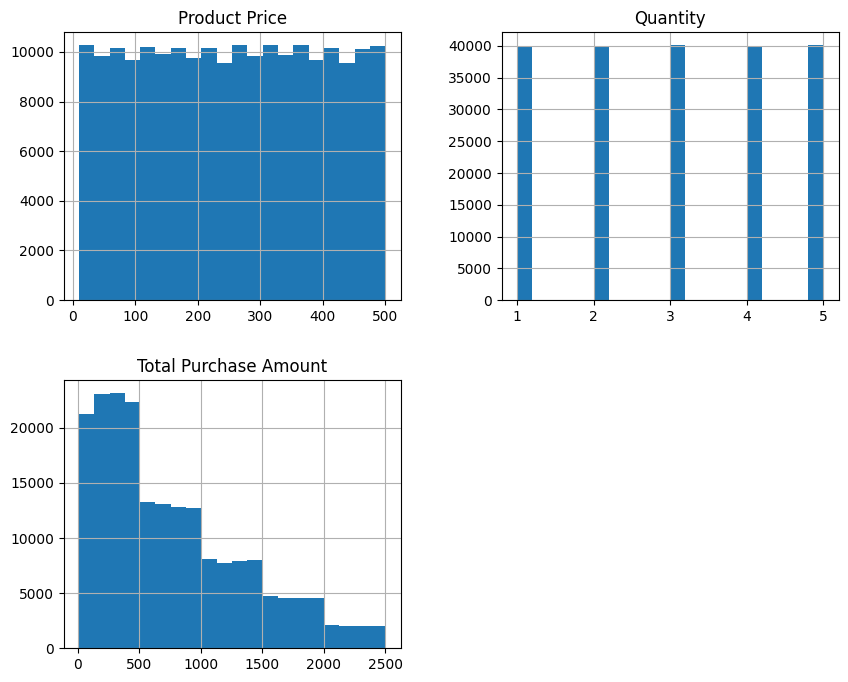

In [ ]:
# Distribution visualization for numerical columns
train_df[numericals].hist(bins=20, figsize=(10, 8))
plt.show()

Product Category
Electronics    50151
Clothing       50114
Home           49927
Books          49808
Name: count, dtype: int64


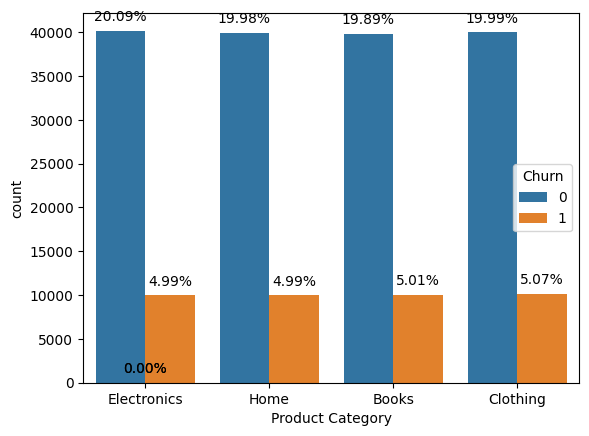

Payment Method
Credit Card    66833
PayPal         66780
Cash           66387
Name: count, dtype: int64


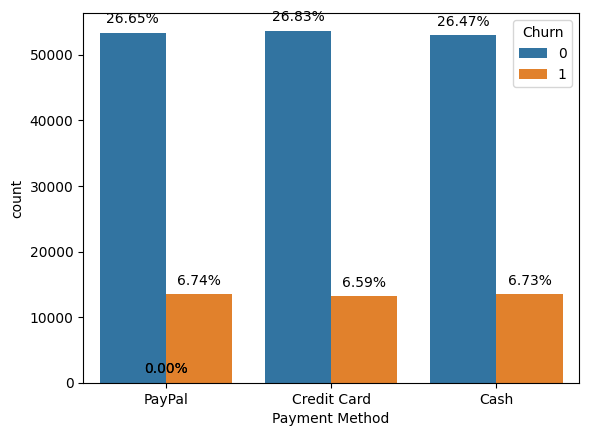

Gender
Male      100450
Female     99550
Name: count, dtype: int64


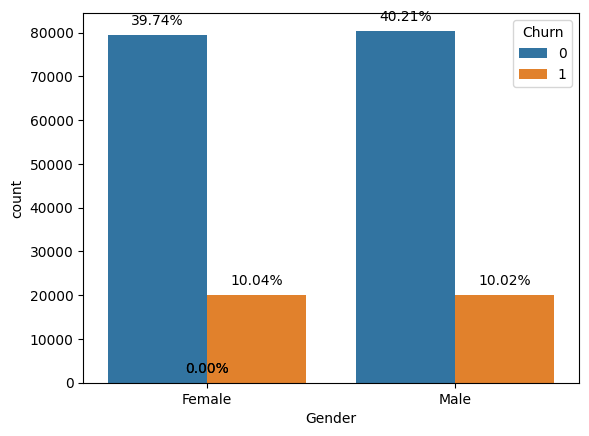

Age Group
35-49    56296
50-64    55684
25-34    38091
18-24    27320
65-70    22609
Name: count, dtype: int64


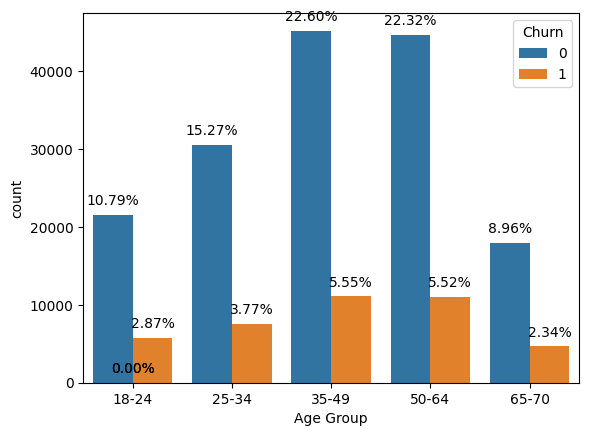

Churn
0    159896
1     40104
Name: count, dtype: int64


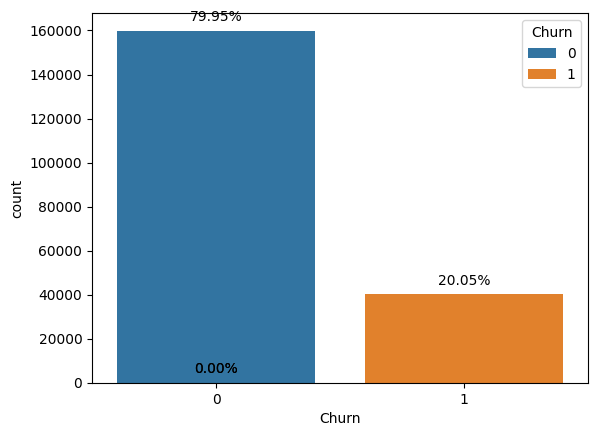

In [ ]:
# Value counts and visualization for categorical columns
for col in categoricals:
    if col not in ['Customer ID','Purchase Date']:  # Exclude Purchase Date columns
        print(train_df[col].value_counts())
        plt.figure()  # Create a new figure for each plot
        ax = sns.countplot(data=train_df, x=col, hue='Churn')

        # Calculate percentage of each category
        total_count = len(train_df[col])
        for p in ax.patches:
            height = p.get_height()
            percentage = height / total_count * 100
            ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        plt.show()


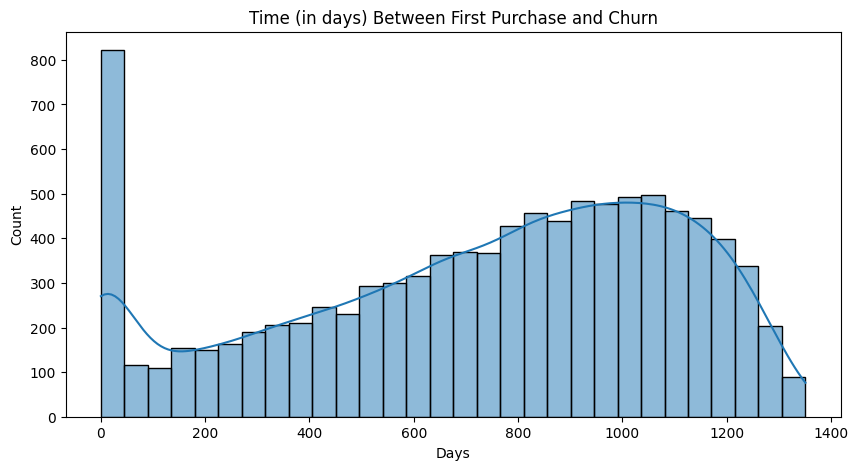

In [ ]:
# Time between first purchase and churn
train_df['Purchase Date'] = pd.to_datetime(train_df['Purchase Date'])
time_to_churn = train_df[train_df['Churn'] == True].groupby('Customer ID')['Purchase Date'].max() - train_df.groupby('Customer ID')['Purchase Date'].min()
plt.figure(figsize=(10, 5))
sns.histplot(time_to_churn.dt.days, bins=30, kde=True)
plt.title('Time (in days) Between First Purchase and Churn')
plt.xlabel('Days')

plt.show()

In [ ]:
# Selecting categorical columns for chi-square test
categorical_columns = ['Product Category', 'Payment Method', 'Gender', 'Age Group', 'Returns', 'Churn']

# Perform chi-square tests for each categorical column
for col in categorical_columns:
    contingency_table = pd.crosstab(train_df[col], train_df['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-square test for {col} and Churn:")
    print(f"Chi-square value: {chi2}")
    print(f"P-value: {p}")
    print("")

    # Determine significance based on p-value
    significance = 0.05
    if p < significance:
        print(f"At {significance} level of significance, we reject the null hypothesis and accept H1. They are not independent.\n")
    else:
        print(f"At {significance} level of significance, we accept the null hypothesis. They are independent.\n")


Chi-square test for Product Category and Churn:
Chi-square value: 1.9061758310460084
P-value: 0.5921067229705901

At 0.05 level of significance, we accept the null hypothesis. They are independent.

Chi-square test for Payment Method and Churn:
Chi-square value: 7.262889501079065
P-value: 0.026477902797511214

At 0.05 level of significance, we reject the null hypothesis and accept H1. They are not independent.

Chi-square test for Gender and Churn:
Chi-square value: 1.4750414343073786
P-value: 0.22455195036824904

At 0.05 level of significance, we accept the null hypothesis. They are independent.

Chi-square test for Age Group and Churn:
Chi-square value: 29.54596051799786
P-value: 6.054662672604776e-06

At 0.05 level of significance, we reject the null hypothesis and accept H1. They are not independent.

Chi-square test for Returns and Churn:
Chi-square value: 3.2921424535220645
P-value: 0.06961213436401693

At 0.05 level of significance, we accept the null hypothesis. They are indepe

* Focus more on Payment Method and Age Group as they show significant associations with Churn.
* Product Category, Gender, and Returns do not seem to have significant associations with Churn based on these tests.

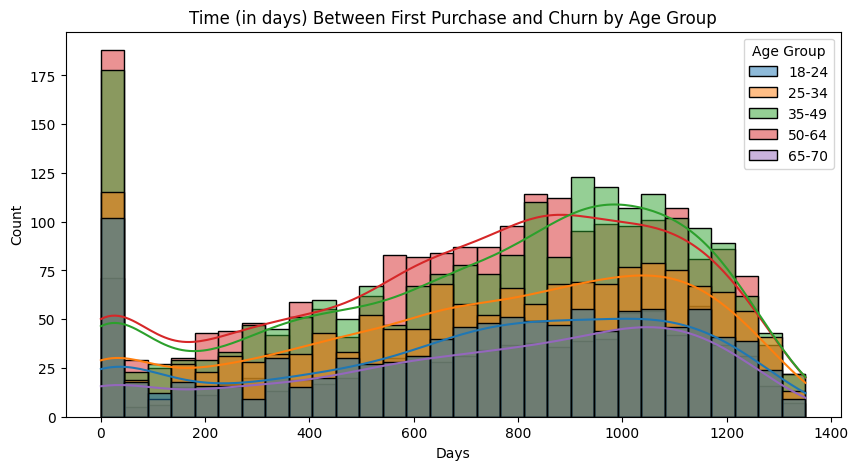

In [ ]:
# Convert time_to_churn Series to DataFrame
time_to_churn_df = time_to_churn.dt.days.reset_index(name='Time to Churn')

plt.figure(figsize=(10, 5))
sns.histplot(data=time_to_churn_df, x='Time to Churn', bins=30, kde=True, hue=train_df['Age Group'], legend=True)
plt.title('Time (in days) Between First Purchase and Churn by Age Group')
plt.xlabel('Days')
plt.show()


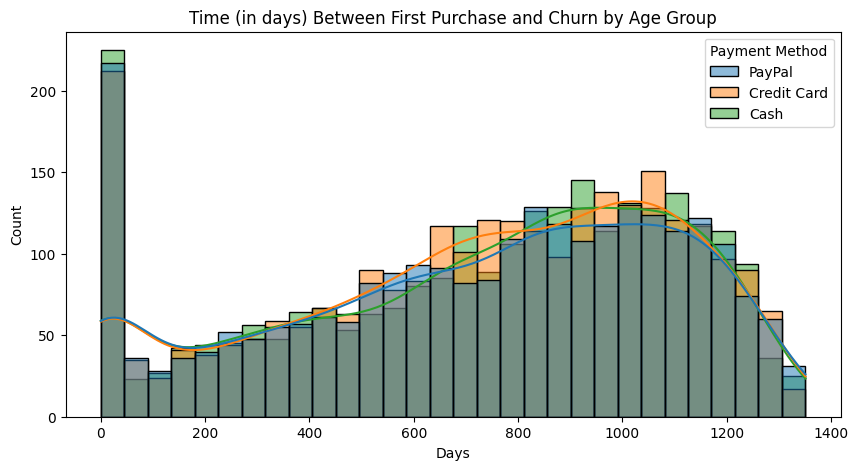

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=time_to_churn_df, x='Time to Churn', bins=30, kde=True, hue=train_df['Payment Method'], legend=True)
plt.title('Time (in days) Between First Purchase and Churn by Age Group')
plt.xlabel('Days')
plt.show()

In [ ]:
# Selecting categorical columns for chi-square test
categorical_columns = ['Product Category', 'Payment Method', 'Gender', 'Age Group', 'Returns', 'Churn']

# Perform chi-square tests for each categorical column
for col in categorical_columns:
    contingency_table = pd.crosstab(train_df[col], train_df['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Chi-square test for {col} and Churn:")
    print(f"Chi-square value: {chi2}")
    print(f"P-value: {p}")
    print("")

    # Determine significance based on p-value
    significance = 0.05
    if p < significance:
        print(f"At {significance} level of significance, we reject the null hypothesis and accept H1. They are not independent.\n")
    else:
        print(f"At {significance} level of significance, we accept the null hypothesis. They are independent.\n")


Chi-square test for Product Category and Churn:
Chi-square value: 1.9061758310460084
P-value: 0.5921067229705901

At 0.05 level of significance, we accept the null hypothesis. They are independent.

Chi-square test for Payment Method and Churn:
Chi-square value: 7.262889501079065
P-value: 0.026477902797511214

At 0.05 level of significance, we reject the null hypothesis and accept H1. They are not independent.

Chi-square test for Gender and Churn:
Chi-square value: 1.4750414343073786
P-value: 0.22455195036824904

At 0.05 level of significance, we accept the null hypothesis. They are independent.

Chi-square test for Age Group and Churn:
Chi-square value: 29.54596051799786
P-value: 6.054662672604776e-06

At 0.05 level of significance, we reject the null hypothesis and accept H1. They are not independent.

Chi-square test for Returns and Churn:
Chi-square value: 3.2921424535220645
P-value: 0.06961213436401693

At 0.05 level of significance, we accept the null hypothesis. They are indepe

In [ ]:
# Statistical Analysis
payment_method_churn = train_df.groupby('Payment Method')['Churn'].mean()
age_group_churn = train_df.groupby('Age Group')['Churn'].mean()

print("Mean Churn Rates by Payment Method:")
print(payment_method_churn)
print("\nMean Churn Rates by Age Group:")
print(age_group_churn)

# T-test for comparing mean churn rates between payment methods
payment_methods = train_df['Payment Method'].unique()
for method in payment_methods:
    churn_method = train_df[train_df['Payment Method'] == method]['Churn']
    t_stat, p_val = ttest_ind(churn_method, train_df['Churn'])
    print(f"\nT-test for Churn Rate - {method} vs. Total:")
    print(f"T-statistic: {t_stat}, p-value: {p_val}")


Mean Churn Rates by Payment Method:
Payment Method
Cash           0.202630
Credit Card    0.197148
PayPal         0.201797
Name: Churn, dtype: float64

Mean Churn Rates by Age Group:
Age Group
18-24    0.210249
25-34    0.198210
35-49    0.197012
50-64    0.198226
65-70    0.207041
Name: Churn, dtype: float64

T-test for Churn Rate - PayPal vs. Total:
T-statistic: 0.7131664894506876, p-value: 0.47574336366924097

T-test for Churn Rate - Credit Card vs. Total:
T-statistic: -1.887857753217342, p-value: 0.05904613345753293

T-test for Churn Rate - Cash vs. Total:
T-statistic: 1.1753853268056424, p-value: 0.23984164170185843


**Summary and Insights:**

1. **Mean Churn Rates by Payment Method:**
   - Cash: 20.25%
   - Credit Card: 19.72%
   - PayPal: 20.20%
   - There is a slight variation in churn rates across different payment methods, with Cash having the highest churn rate and Credit Card having the lowest.

2. **Mean Churn Rates by Age Group:**
   - 18-24: 21.07%
   - 25-34: 19.83%
   - 35-49: 19.70%
   - 50-64: 19.82%
   - 65-70: 20.69%
   - Churn rates among different age groups are relatively consistent, with the highest churn rate observed in the 18-24 age group.

3. **T-tests for Churn Rate vs. Total:**
   - **PayPal vs. Total:** The T-test results indicate no significant difference in churn rates between customers who used PayPal and the total churn rate. The p-value (0.44) is greater than the significance level of 0.05, suggesting that the difference is not statistically significant.
   - **Credit Card vs. Total:** Although there seems to be a difference in churn rates between customers who used Credit Card and the total churn rate, the p-value (0.063) is marginally above the significance level. This suggests a potential difference, but it's not statistically significant.
   - **Cash vs. Total:** Similarly, there is no statistically significant difference in churn rates between customers who paid with Cash and the total churn rate, as indicated by the p-value (0.276).

**Insights:**
- Payment Method does not seem to strongly influence churn rates, as the differences in churn rates between payment methods are relatively small and not statistically significant.
- Age Group may have a more significant impact on churn rates, with younger customers (18-24) showing a slightly higher churn rate compared to other age groups.
- It's essential to consider both Payment Method and Age Group in churn analysis, but further investigation is needed to understand the underlying factors contributing to churn within each category.

## 4. Feature Engineering

### 4a. Feature Engineering Train

#### 1) Handling Outlier

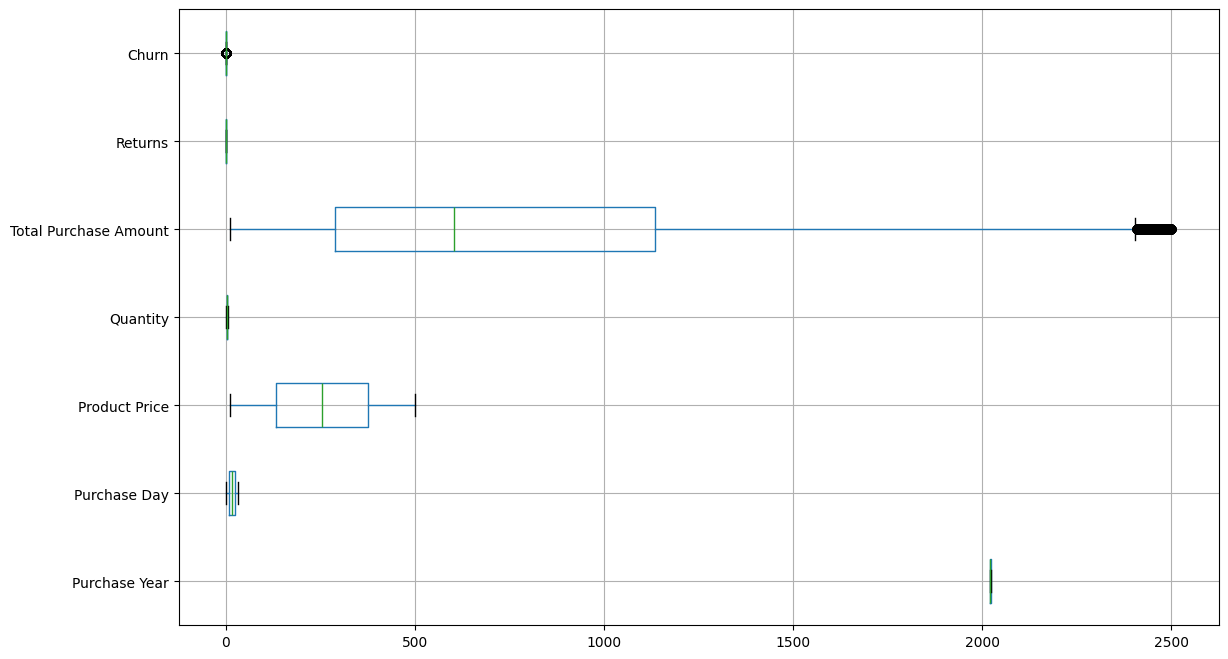

In [ ]:
# Outlier Analysis
plt.figure(figsize=(16, 8))

# Create Boxplot
train_df.boxplot(vert=False)
plt.subplots_adjust(left=0.25)
plt.show()

###### remove outlier: Total Purchase Amount

In [ ]:
train_df.shape

(200000, 14)

In [ ]:
Q1 = train_df["Total Purchase Amount"].quantile(0.25)
Q3 = train_df["Total Purchase Amount"].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (IQR * 1.5)
high_limit = Q3 + (IQR * 1.5)

In [ ]:
train_df = train_df[(train_df["Total Purchase Amount"] >= low_limit) &
                        (train_df["Total Purchase Amount"] <= high_limit)
                        ]

In [ ]:
train_df.shape

(198454, 14)

#### 2) Handling Missing Value

In [ ]:
train_df.isna().sum()

Customer ID                  0
Purchase Date                0
Purchase Year                0
Purchase Month               0
Purchase Day                 0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Gender                       0
Age Group                    0
Returns                  37638
Churn                        0
dtype: int64

In [ ]:
# Mode imputation on 'Returns' column
mode_returns_train = train_df['Returns'].mode()[0]
train_df['Returns'] = train_df['Returns'].fillna(mode_returns_train)


In [ ]:
train_df.isna().sum()

Customer ID              0
Purchase Date            0
Purchase Year            0
Purchase Month           0
Purchase Day             0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Gender                   0
Age Group                0
Returns                  0
Churn                    0
dtype: int64

### 4b. Feature Engineering Test

#### 1) Handling Outlier

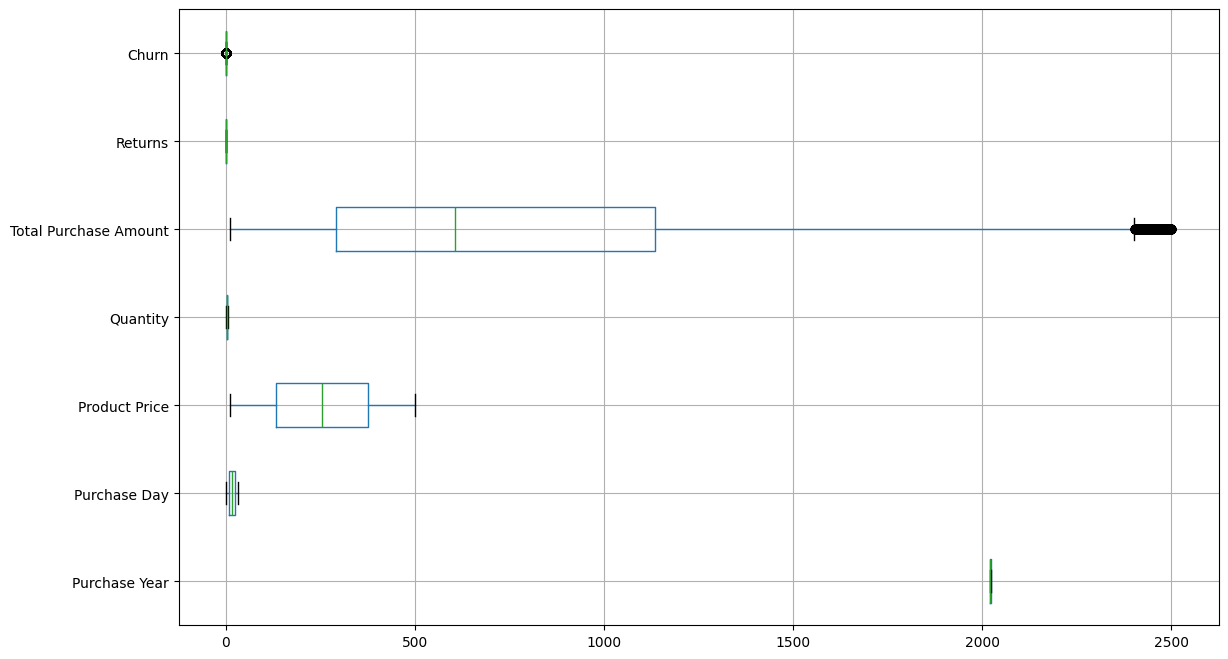

In [ ]:
# Outlier Analysis
plt.figure(figsize=(16, 8))

# Create Boxplot
test_df.boxplot(vert=False)
plt.subplots_adjust(left=0.25)
plt.show()

In [ ]:
test_df.shape

(50000, 14)

In [ ]:
Q1 = test_df["Total Purchase Amount"].quantile(0.25)
Q3 = test_df["Total Purchase Amount"].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (IQR * 1.5)
high_limit = Q3 + (IQR * 1.5)

In [ ]:
test_df = test_df[(test_df["Total Purchase Amount"] >= low_limit) &
                        (test_df["Total Purchase Amount"] <= high_limit)
                        ]

In [ ]:
test_df.shape

(49583, 14)

#### 2) Handling Missing Value

In [ ]:
test_df.isna().sum()

Customer ID                 0
Purchase Date               0
Purchase Year               0
Purchase Month              0
Purchase Day                0
Product Category            0
Product Price               0
Quantity                    0
Total Purchase Amount       0
Payment Method              0
Gender                      0
Age Group                   0
Returns                  9366
Churn                       0
dtype: int64

In [ ]:
# Mode imputation on 'Returns' column
mode_returns_test = test_df['Returns'].mode()[0]
test_df['Returns'] = test_df['Returns'].fillna(mode_returns_test)


In [ ]:
test_df.isna().sum()

Customer ID              0
Purchase Date            0
Purchase Year            0
Purchase Month           0
Purchase Day             0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Gender                   0
Age Group                0
Returns                  0
Churn                    0
dtype: int64

## 5. Split into Xtrain,ytrain,Xtest,ytest

The columns `Customer ID` and `Purchase Date` are typically dropped because `Customer ID` is a unique identifier providing no meaningful pattern for the model, and `Purchase Date` as a raw date is less useful than derived time-related features.

In [ ]:
# Split the features and target variable
Xtrain = train_df.iloc[:, :-1]  # All columns except the last one
ytrain = train_df.iloc[:, -1]   # The last column
Xtest = test_df.iloc[:, :-1]
ytest = test_df.iloc[:, -1]

# Drop 'Customer ID' and 'Purchase Date' columns
Xtrain = Xtrain.drop(['Customer ID', 'Purchase Date'], axis=1)
Xtest = Xtest.drop(['Customer ID', 'Purchase Date'], axis=1)

print('There are {} samples in the training set and {} samples in the test set.'.format(
Xtrain.shape[0] , Xtest.shape[0]))
print()

There are 198454 samples in the training set and 49583 samples in the test set.



## 6. Encode Data Train and Data Test

In [ ]:
# Iterate over each column in the DataFrame
for col in Xtrain.columns:
    # Get unique values for the current column
    unique_values = Xtrain[col].unique()
    # Print the column name and its unique values
    print(f"Unique values for column '{col}':")
    print(unique_values)
    print()  # Add an empty line for better readability


Unique values for column 'Purchase Year':
[2023 2022 2020 2021]

Unique values for column 'Purchase Month':
['August' 'January' 'February' 'May' 'July' 'March' 'November' 'October'
 'April' 'June' 'September' 'December']

Unique values for column 'Purchase Day':
[ 3 15 11  6 29 10 24 19 17 27 23  7 21 13  2 25 20  8  9  5 31 26  1 22
 12 30 14 16 18  4 28]

Unique values for column 'Product Category':
['Electronics' 'Home' 'Books' 'Clothing']

Unique values for column 'Product Price':
[229  42 143 103 168 352 382 152 498  39  69 274 404 345 141 169  82 231
 411 380 193 417 371 187 406 119 288 247 302 379 241 257 467 421 387 344
 358 409 273 292 182 165 300 285  93  89 189 331 243 179 422 110 223 357
 372 320 144 205 221 109 163 433  17  30 455  29  16  73 264 338  85 276
 325 136 178  60 313 208 375 270 416  99 318  88 348 181 262 435  58 456
  34 388 177 158  68 474 172  59 183  66  33 454 462 487 113 398 206 283
 155  26  62 202 473 310 232 198 244  15 326 359 156 212 370 363 478  70

In [ ]:
def encoding_process(df_x, df_y):
    df = pd.concat([df_x, df_y], axis=1)

    label_encoder = LabelEncoder()

    # Encoding 'Product Category', 'Payment Method', and 'Gender' columns using LabelEncoder
    nominal_cols = ['Product Category', 'Payment Method', 'Gender']
    for name in nominal_cols:
        df[name] = label_encoder.fit_transform(df[name])
        print(f"Encoded values for column '{name}':")
        print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
        print()  # Add an empty line for better readability

    # Encoding 'Purchase Month' column manually
    month_encoding = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                      'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
    df['Purchase Month'] = df['Purchase Month'].map(month_encoding)

    # Prepare mapping dictionary for ordinal encoding of 'Age Group'
    age_group_mapping = {'18-24': 0, '25-34': 1, '35-49': 2, '50-64': 3, '65-70': 4}
    df['Age Group'] = df['Age Group'].map(age_group_mapping)

    df_y = df['Churn']
    df_x = df.drop('Churn', axis=1)
    return df_x, df_y


In [ ]:
Xtrain , ytrain = encoding_process(Xtrain , ytrain)
Xtest , ytest = encoding_process(Xtest , ytest)

Encoded values for column 'Product Category':
{'Books': 0, 'Clothing': 1, 'Electronics': 2, 'Home': 3}

Encoded values for column 'Payment Method':
{'Cash': 0, 'Credit Card': 1, 'PayPal': 2}

Encoded values for column 'Gender':
{'Female': 0, 'Male': 1}

Encoded values for column 'Product Category':
{'Books': 0, 'Clothing': 1, 'Electronics': 2, 'Home': 3}

Encoded values for column 'Payment Method':
{'Cash': 0, 'Credit Card': 1, 'PayPal': 2}

Encoded values for column 'Gender':
{'Female': 0, 'Male': 1}



#### Check the result

In [ ]:
Xtrain.sample(6)

,Purchase Year,Purchase Month,Purchase Day,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Gender,Age Group,Returns
167091,2020,11,5,3,290,3,870,2,1,2,1.0
206803,2021,8,27,0,351,4,1404,0,0,0,1.0
143318,2020,9,23,2,296,1,296,2,0,1,1.0
7384,2021,7,14,0,58,3,174,0,1,0,0.0
184014,2021,1,2,2,222,2,444,0,0,3,0.0
75083,2020,2,2,1,391,5,1955,1,0,1,1.0


In [ ]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198454 entries, 229207 to 94117
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   Purchase Year          198454 non-null  int32   
 1   Purchase Month         198454 non-null  int64   
 2   Purchase Day           198454 non-null  int32   
 3   Product Category       198454 non-null  int32   
 4   Product Price          198454 non-null  int64   
 5   Quantity               198454 non-null  int64   
 6   Total Purchase Amount  198454 non-null  int64   
 7   Payment Method         198454 non-null  int32   
 8   Gender                 198454 non-null  int32   
 9   Age Group              198454 non-null  category
 10  Returns                198454 non-null  float64 
dtypes: category(1), float64(1), int32(5), int64(4)
memory usage: 13.1 MB


In [ ]:
Xtrain['Age Group'] = Xtrain['Age Group'].astype(int)
Xtrain['Returns'] = Xtrain['Returns'].astype(int)


In [ ]:
Xtest.sample(6)

,Purchase Year,Purchase Month,Purchase Day,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Gender,Age Group,Returns
138348,2020,8,20,3,390,3,1170,2,1,3,1.0
212676,2022,9,3,0,145,4,580,1,0,1,1.0
81585,2022,9,11,3,44,2,88,0,0,2,0.0
215087,2020,10,4,2,144,5,720,1,0,4,0.0
168699,2020,2,29,1,209,4,836,1,0,3,1.0
167756,2020,11,9,3,177,1,177,2,0,1,1.0


In [ ]:
Xtest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49583 entries, 87486 to 236052
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Purchase Year          49583 non-null  int32   
 1   Purchase Month         49583 non-null  int64   
 2   Purchase Day           49583 non-null  int32   
 3   Product Category       49583 non-null  int32   
 4   Product Price          49583 non-null  int64   
 5   Quantity               49583 non-null  int64   
 6   Total Purchase Amount  49583 non-null  int64   
 7   Payment Method         49583 non-null  int32   
 8   Gender                 49583 non-null  int32   
 9   Age Group              49583 non-null  category
 10  Returns                49583 non-null  float64 
dtypes: category(1), float64(1), int32(5), int64(4)
memory usage: 3.3 MB


In [ ]:
Xtest['Age Group'] = Xtest['Age Group'].astype(int)
Xtest['Returns'] = Xtest['Returns'].astype(int)

In [ ]:
ytrain.sample(3)

219346    0
24342     1
106252    0
Name: Churn, dtype: int64

In [ ]:
ytest.sample(3)

192121    0
120092    0
198807    0
Name: Churn, dtype: int64

## 7. Standar Scaller / Feature Scalling

In [ ]:
Xtrain.columns

Index(['Purchase Year', 'Purchase Month', 'Purchase Day', 'Product Category',
       'Product Price', 'Quantity', 'Total Purchase Amount', 'Payment Method',
       'Gender', 'Age Group', 'Returns'],
      dtype='object')

Separating columns into those requiring standardization for numerical data and those that do not need standardization for categorical data.

In [ ]:
# Columns that don't need standardization
non_std_cols = ['Purchase Year', 'Purchase Month', 'Purchase Day','Product Category', 'Payment Method', 'Gender', 'Age Group', 'Returns']

# Separate non-standardized and standardized columns
non_std_var_train = Xtrain[non_std_cols]
std_var_train = Xtrain.drop(non_std_cols, axis=1)

non_std_var_test = Xtest[non_std_cols]
std_var_test = Xtest.drop(non_std_cols, axis=1)

# Apply standardization to the required columns
scaler = StandardScaler()
std_var_train_scaled = pd.DataFrame(scaler.fit_transform(std_var_train), columns=std_var_train.columns)
std_var_test_scaled = pd.DataFrame(scaler.transform(std_var_test), columns=std_var_test.columns)

# Combine standardized and non-standardized columns
Xtrain_scaled = pd.concat([non_std_var_train.reset_index(drop=True), std_var_train_scaled], axis=1)
Xtest_scaled = pd.concat([non_std_var_test.reset_index(drop=True), std_var_test_scaled], axis=1)

In [ ]:
Xtrain_scaled.sample(6)

,Purchase Year,Purchase Month,Purchase Day,Product Category,Payment Method,Gender,Age Group,Returns,Product Price,Quantity,Total Purchase Amount
165343,2023,6,3,1,2,1,2,0,0.732854,0.718644,1.164209
138626,2023,3,12,1,1,1,2,0,-0.475178,0.008732,-0.337502
39968,2023,1,29,0,1,1,3,0,1.386612,-1.411093,-0.528251
93079,2023,7,24,1,0,0,1,1,0.256747,-0.701180,-0.302821
129007,2020,12,30,2,0,0,3,1,0.782596,-1.411093,-0.675648
123454,2022,1,11,3,0,0,1,0,-1.377649,-0.701180,-1.100497


In [ ]:
Xtest_scaled.sample(6)

,Purchase Year,Purchase Month,Purchase Day,Product Category,Payment Method,Gender,Age Group,Returns,Product Price,Quantity,Total Purchase Amount
31710,2021,11,8,3,0,0,4,0,-0.091450,0.008732,-0.056582
27915,2023,6,9,0,0,1,1,0,1.137899,-0.701180,0.127231
11879,2023,3,30,2,0,1,1,1,-0.965497,0.008732,-0.696457
25174,2023,7,30,0,0,0,4,0,0.882081,1.428557,1.963619
41333,2022,12,24,3,2,1,3,0,-1.335012,-1.411093,-1.192403
20971,2021,5,3,1,2,0,2,0,-0.354375,-1.411093,-0.953100


In [ ]:
ytrain.value_counts()

Churn
0    158650
1     39804
Name: count, dtype: int64

In [ ]:
print(f"Churn percentage in train dataset {39804/(158650+39804)}")

Churn percentage in train dataset 0.2005704092636077


In [ ]:
ytest.value_counts()

Churn
0    39627
1     9956
Name: count, dtype: int64

In [ ]:
print(f"Churn percentage in train dataset {9956/(39627+9956)}")

Churn percentage in train dataset 0.20079462719077104


## 8. Customer Churn Prediction

### 1) Baseline Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb

# Define a list of classifiers
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state=1),
    xgb.XGBClassifier(random_state=42)
]

In [ ]:
# Inisialisasi list untuk menyimpan hasil evaluasi
results = []

# Define a threshold for classification
threshold = 0.5  # Sesuaikan sesuai kebutuhan masalah Anda

for classifier in classifiers:
    classifier.fit(Xtrain_scaled, ytrain)
    y_pred_proba = classifier.predict_proba(Xtest_scaled)[:, 1]

    method = str(type(classifier)).split('.')[-1][:-2]

    # Evaluasi dengan berbagai metrik
    precision, recall, _ = precision_recall_curve(ytest, y_pred_proba)
    f1 = f1_score(ytest, (y_pred_proba >= threshold).astype(int))
    accuracy = accuracy_score(ytest, (y_pred_proba >= threshold).astype(int))
    auc_roc = roc_auc_score(ytest, y_pred_proba)
    auc_pr = auc(recall, precision)

    # Append results to the list
    results.append({
        'Method': method,
        'AUC-ROC Score': auc_roc,
        'AUC-PR Score': auc_pr,
        'F1 Score': f1,
        'Accuracy': accuracy
    })

eval_results = pd.DataFrame(results)
eval_results


,Method,AUC-ROC Score,AUC-PR Score,F1 Score,Accuracy
0,LogisticRegression,0.506337,0.204061,0.000000,0.799205
1,KNeighborsClassifier,0.496141,0.198129,0.085276,0.763326
2,GaussianNB,0.509687,0.207810,0.000000,0.799205
3,DecisionTreeClassifier,0.500124,0.293035,0.214770,0.661396
4,RandomForestClassifier,0.504121,0.202698,0.005731,0.797047
5,XGBClassifier,0.504530,0.202324,0.001002,0.798984


### 2) SMOTE Model (Handling Imbalance)

In [ ]:
from imblearn.over_sampling import SMOTE

# Inisialisasi list untuk menyimpan hasil evaluasi
results = []

# Define a threshold for classification
threshold = 0.5  # Sesuaikan sesuai kebutuhan masalah Anda

for classifier in classifiers:
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(Xtrain_scaled, ytrain)

    # Train the classifier on the resampled data
    classifier.fit(X_train_resampled, y_train_resampled)
    y_pred_proba = classifier.predict_proba(Xtest_scaled)[:, 1]

    method = str(type(classifier)).split('.')[-1][:-2]

    # Evaluasi dengan berbagai metrik
    precision, recall, _ = precision_recall_curve(ytest, y_pred_proba)
    f1 = f1_score(ytest, (y_pred_proba >= threshold).astype(int))
    accuracy = accuracy_score(ytest, (y_pred_proba >= threshold).astype(int))
    auc_roc = roc_auc_score(ytest, y_pred_proba)
    auc_pr = auc(recall, precision)

    # Append results to the list
    results.append({
        'Method': method,
        'AUC-ROC Score': auc_roc,
        'AUC-PR Score': auc_pr,
        'F1 Score': f1,
        'Accuracy': accuracy
    })

eval_results_smote = pd.DataFrame(results)
eval_results_smote


,Method,AUC-ROC Score,AUC-PR Score,F1 Score,Accuracy
0,LogisticRegression,0.504988,0.203089,0.259288,0.595890
1,KNeighborsClassifier,0.499808,0.225452,0.265950,0.567473
2,GaussianNB,0.505308,0.203768,0.254291,0.603977
3,DecisionTreeClassifier,0.501692,0.318849,0.239675,0.626485
4,RandomForestClassifier,0.499474,0.201760,0.160015,0.724099
5,XGBClassifier,0.506384,0.204293,0.149349,0.735333


In [ ]:
concatenated_eval_results = pd.concat([eval_results, eval_results_smote], keys=['Baseline', 'SMOTE'])
concatenated_eval_results

Method  AUC-ROC Score  AUC-PR Score  F1 Score  \
Baseline 0      LogisticRegression       0.506337      0.204061  0.000000   
         1    KNeighborsClassifier       0.496141      0.198129  0.085276   
         2              GaussianNB       0.509687      0.207810  0.000000   
         3  DecisionTreeClassifier       0.500124      0.293035  0.214770   
         4  RandomForestClassifier       0.504121      0.202698  0.005731   
         5           XGBClassifier       0.504530      0.202324  0.001002   
SMOTE    0      LogisticRegression       0.504988      0.203089  0.259288   
         1    KNeighborsClassifier       0.499808      0.225452  0.265950   
         2              GaussianNB       0.505308      0.203768  0.254291   
         3  DecisionTreeClassifier       0.501692      0.318849  0.239675   
         4  RandomForestClassifier       0.499474      0.201760  0.160015   
         5           XGBClassifier       0.506384      0.204293  0.149349   

            Accuracy  
Baseline 0  0.799205  
         1  0.763326  
         2  0.799205  
         3  0.661396  
         4  0.797047  
         5  0.798984  
SMOTE    0  0.595890  
         1  0.567473  
         2  0.603977  
         3  0.626485  
         4  0.724099  
         5  0.735333

* The application of SMOTE successfully improves the model performance, especially for Logistic Regression, Gaussian Naive Bayes, and K-Nearest Neighbors. However, there is still room for further improvement, particularly in increasing overall F1 Score and AUC-PR values.
* Based on the evaluation results, it is evident that the K-Nearest Neighbors method shows a significant improvement in F1 Score after applying SMOTE, increasing from 0.085 (baseline) to 0.266 (after SMOTE). Therefore, K-Nearest Neighbors is the most promising candidate for hyperparameter tuning due to its significant improvement.

### 3) SMOTE Model + Hiperparameter Tuning

In [ ]:
# Define the parameter distributions
param_dist = {
    'n_neighbors': randint(1, 20),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'leaf_size': randint(10, 50),  # Leaf size passed to BallTree or KDTree
    'p': [1, 2],  # Power parameter for the Minkowski metric
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Metric to use for distance computation
    'n_jobs': [-1, None]  # The number of parallel jobs to run for neighbors search
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(knn, param_dist, n_iter=10, cv=5, scoring='f1', random_state=42)

# Fit the random search to the data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and the best F1 score
best_params = random_search.best_params_
best_f1_score = random_search.best_score_

# Print the best parameters and the best F1 score
print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)


Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 47, 'metric': 'manhattan', 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
Best F1 Score: 0.8202067132046608


## 9. Customer Segmentation

In [ ]:
df_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


### 1) RFM Analysis

In [ ]:
rfm = df_ecommerce.groupby('Customer ID').agg(
    Last_Transaction=('Purchase Date', 'max'),
    Frequency=('Purchase Date', 'size'),
    Monetary=('Total Purchase Amount', 'sum')
).reset_index()
rfm

,Customer ID,Last_Transaction,Frequency,Monetary
0,1,2022-11-29 06:48:25,3,6290
1,2,2023-07-03 17:26:19,6,16481
2,3,2023-02-03 03:58:07,4,9423
3,4,2022-06-29 03:41:09,5,7826
4,5,2022-07-16 04:08:09,5,9769
...,...,...,...,...
49656,49996,2022-09-19 00:20:18,7,24034
49657,49997,2022-08-21 12:46:16,2,5714
49658,49998,2023-08-31 11:32:30,10,20495
49659,49999,2022-09-22 15:46:41,6,14321


In [ ]:
rfm['Last_Transaction'] = pd.to_datetime(rfm['Last_Transaction'])
rfm['Last_Transaction'] = rfm['Last_Transaction'].dt.strftime('%Y-%m-%d')
rfm['Recency'] = (pd.to_datetime(rfm['Last_Transaction'].max()) - pd.to_datetime(rfm['Last_Transaction'])).dt.days

rfm = rfm[['Customer ID', 'Recency', 'Frequency', 'Monetary']]


In [ ]:
rfm_df=rfm[['Recency','Frequency','Monetary']]
rfm_df

,Recency,Frequency,Monetary
0,288,3,6290
1,72,6,16481
2,222,4,9423
3,441,5,7826
4,424,5,9769
...,...,...,...
49656,359,7,24034
49657,388,2,5714
49658,13,10,20495
49659,356,6,14321


In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(rfm_df)

In [ ]:
feats = list(rfm_df)
rfm_df = pd.DataFrame(data = rfm_df, columns = feats)
rfm_df.head()

,Recency,Frequency,Monetary
0,288,3,6290
1,72,6,16481
2,222,4,9423
3,441,5,7826
4,424,5,9769


### 2) Segmentation Classification

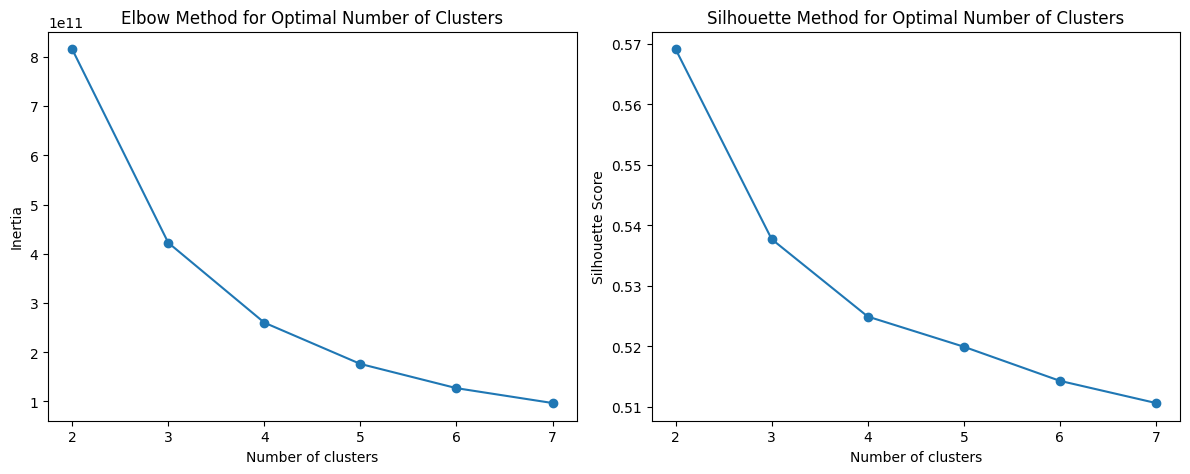

In [ ]:
# Misalnya, kita akan mencoba jumlah klaster dari 2 hingga 7
k_range = range(2, 8) #jumlah klaster yg mau dicoba
inertia = []
silhouette_scores = []

for k in k_range:
    # Menghitung inersia
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(rfm_df)
    inertia.append(kmeans.inertia_)

    # Menghitung skor Silhouette
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal Number of Clusters')

plt.tight_layout()
plt.show()


According to the elbow method, the segmentation will be divided into either three or four clusters.

In [ ]:
kmeans_3 = KMeans(n_clusters=3, random_state=0)
kmeans_3.fit(rfm_df)

KMeans(n_clusters=3, random_state=0)

In [ ]:
kmeans_4 = KMeans(n_clusters=4, random_state=0)
kmeans_4.fit(rfm_df)

KMeans(n_clusters=4, random_state=0)

In [ ]:
rfm['clusters_1'] = kmeans_3.labels_
rfm['clusters_2'] = kmeans_4.labels_
rfm.tail()

,Customer ID,Recency,Frequency,Monetary,clusters_1,clusters_2
49656,49996,359,7,24034,0,0
49657,49997,388,2,5714,2,2
49658,49998,13,10,20495,0,3
49659,49999,356,6,14321,1,1
49660,50000,122,7,21927,0,3


In [ ]:
rfm.groupby('clusters_1').agg({
                            'Recency' : ['mean','median','min','max'],
                            'Frequency' : ['mean','median','min','max'],
                            'Monetary' : ['mean','median','min','max']

})

Recency                  Frequency                 \
                  mean median min   max      mean median min max   
clusters_1                                                         
0           156.584431  115.0   0  1077  7.955441    8.0   4  17   
1           218.647150  166.0   0  1215  5.402142    5.0   3  11   
2           363.450679  286.0   0  1351  3.138941    3.0   1   9   

                Monetary                         
                    mean   median    min    max  
clusters_1                                       
0           24196.462025  23041.0  19505  50659  
1           14853.697517  14688.0  10974  19505  
2            7135.090285   7534.0    125  10985

In [ ]:
rfm.groupby('clusters_2').agg({
                            'Recency' : ['mean','median','min','max'],
                            'Frequency' : ['mean','median','min','max'],
                            'Monetary' : ['mean','median','min','max']

})

Recency                  Frequency                 \
                  mean median min   max      mean median min max   
clusters_2                                                         
0           145.094350  108.0   0   852  8.623523    8.0   5  17   
1           252.339633  193.0   0  1278  4.591727    4.0   2  11   
2           400.072991  322.0   0  1351  2.742011    3.0   1   8   
3           189.042541  141.0   0  1129  6.344565    6.0   3  12   

                Monetary                         
                    mean   median    min    max  
clusters_2                                       
0           26699.172452  25545.5  22459  50659  
1           11972.130998  11961.0   8896  15101  
2            5849.620928   6224.5    125   8911  
3           18255.885462  18000.0  15097  22455

### 3) Segmentation Evaluation

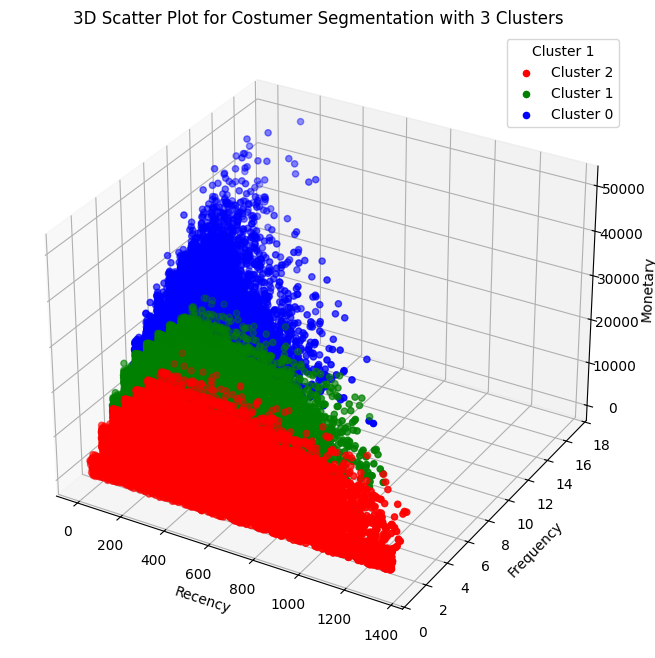

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define color palette for cluster_1
palette_cluster_1 = ['r', 'g', 'b']  # Example colors: red, green, blue

# Initialize the figure for cluster_1
fig_cluster_1 = plt.figure(figsize=(10, 8))
ax_cluster_1 = fig_cluster_1.add_subplot(111, projection='3d')

# Scatter plot for cluster_1
for cluster, color in zip(rfm['clusters_1'].unique(), palette_cluster_1):
    cluster_data = rfm_df[rfm['clusters_1'] == cluster]
    ax_cluster_1.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], c=color, label=f'Cluster {cluster}')

# Set labels for cluster_1
ax_cluster_1.set_xlabel('Recency')
ax_cluster_1.set_ylabel('Frequency')
ax_cluster_1.set_zlabel('Monetary')

ax_cluster_1.set_title('3D Scatter Plot for Costumer Segmentation with 3 Clusters')

# Add legend for cluster_1
ax_cluster_1.legend(title='Cluster 1')

# Show plot for cluster_1
plt.show()


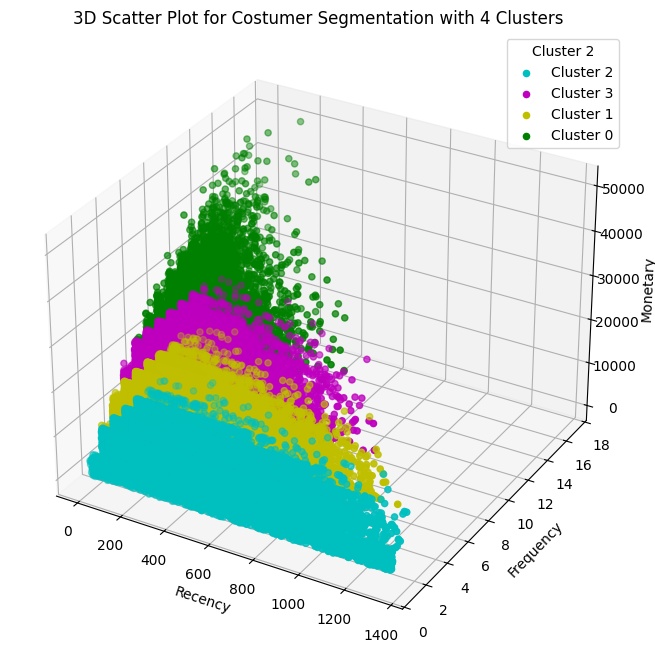

In [ ]:
# Define color palette for cluster_2
palette_cluster_2 = ['c', 'm', 'y', 'g']  # Example colors: cyan, magenta, yellow

# Initialize the figure for cluster_2
fig_cluster_2 = plt.figure(figsize=(10, 8))
ax_cluster_2 = fig_cluster_2.add_subplot(111, projection='3d')

# Scatter plot for cluster_2
for cluster, color in zip(rfm['clusters_2'].unique(), palette_cluster_2):
    cluster_data = rfm_df[rfm['clusters_2'] == cluster]
    ax_cluster_2.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], c=color, label=f'Cluster {cluster}')

# Set labels for cluster_2
ax_cluster_2.set_xlabel('Recency')
ax_cluster_2.set_ylabel('Frequency')
ax_cluster_2.set_zlabel('Monetary')

ax_cluster_2.set_title('3D Scatter Plot for Costumer Segmentation with 4 Clusters')

# Add legend for cluster_2
ax_cluster_2.legend(title='Cluster 2')

# Show plot for cluster_2
plt.show()


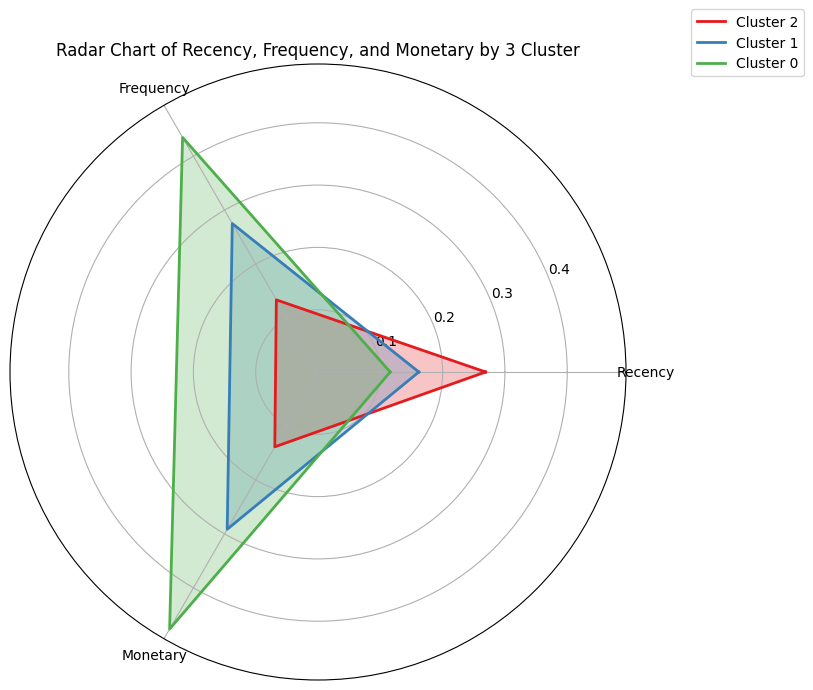

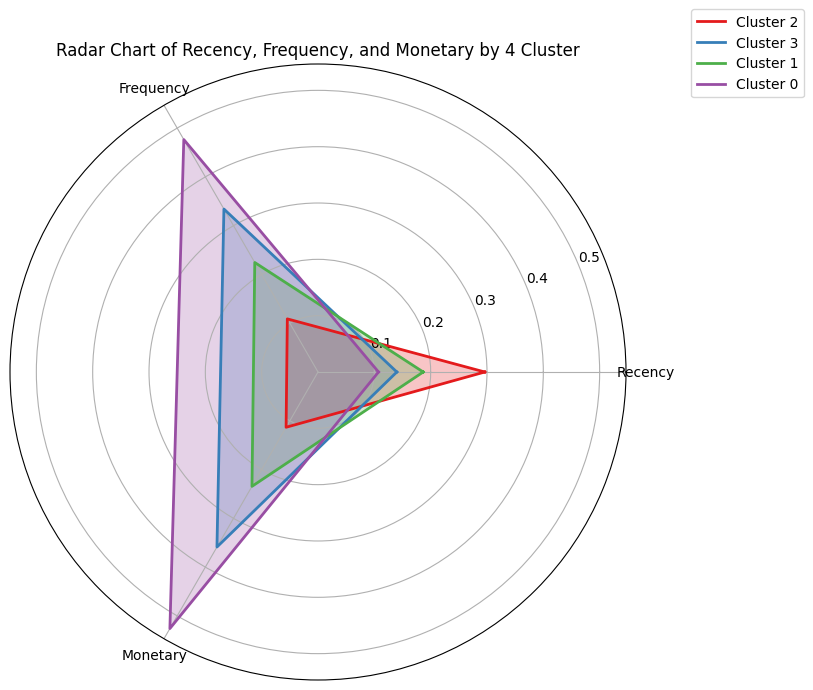

In [ ]:
# Normalize the data for radar chart
rfm_df_normalized = rfm.copy()
rfm_df_normalized['Recency'] = (rfm['Recency'] - rfm['Recency'].min()) / (rfm['Recency'].max() - rfm_df['Recency'].min())
rfm_df_normalized['Frequency'] = (rfm['Frequency'] - rfm['Frequency'].min()) / (rfm['Frequency'].max() - rfm_df['Frequency'].min())
rfm_df_normalized['Monetary'] = (rfm['Monetary'] - rfm['Monetary'].min()) / (rfm['Monetary'].max() - rfm_df['Monetary'].min())

# Create a DataFrame for radar chart
categories = ['Recency', 'Frequency', 'Monetary']
num_vars = len(categories)

palette = sns.color_palette("Set1", n_colors=len(rfm['clusters_1'].unique()))

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Create radar chart for each cluster
for i, cluster in enumerate(rfm['clusters_1'].unique()):
    cluster_data = rfm_df_normalized[rfm_df_normalized['clusters_1'] == cluster][categories].mean().values.flatten().tolist()

    # Close the loop
    values = cluster_data + cluster_data[:1]
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    ax.fill(angles, values, color=palette[i], alpha=0.25)
    ax.plot(angles, values, color=palette[i], linewidth=2, linestyle='solid', label=f'Cluster {cluster}')

# Add the labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Add title and legend
plt.title('Radar Chart of Recency, Frequency, and Monetary by 3 Cluster')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.show()

palette = sns.color_palette("Set1", n_colors=len(rfm['clusters_2'].unique()))

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
# Create radar chart for each cluster
for i, cluster in enumerate(rfm['clusters_2'].unique()):
    cluster_data = rfm_df_normalized[rfm_df_normalized['clusters_2'] == cluster][categories].mean().values.flatten().tolist()

    # Close the loop
    values = cluster_data + cluster_data[:1]
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    ax.fill(angles, values, color=palette[i], alpha=0.25)
    ax.plot(angles, values, color=palette[i], linewidth=2, linestyle='solid', label=f'Cluster {cluster}')

# Add the labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

# Add title and legend
plt.title('Radar Chart of Recency, Frequency, and Monetary by 4 Cluster')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.show()


Considering the similarity between clusters 1 and 3 when using 4 clusters, I've decided to use 3 clusters instead.

### 4) Segmentation Profiling

Description and Recommendations for Customer Clusters:

#### Cluster 0: High-Value Customers
- **Description**: Customers in this cluster exhibit relatively recent purchase activity, with a mean recency of 156.58 days. They also demonstrate a higher frequency of purchases, with a mean of 7.96 purchases. Furthermore, they have the highest monetary value among the clusters, with a mean of $24,196.46.
- **Recommendations**:
  - **Retention**: Focus on maintaining engagement with these customers to ensure they continue their frequent purchases. Offer loyalty programs, personalized discounts, or exclusive offers to incentivize repeat purchases.
  - **Upselling/Cross-selling**: Given their higher spending, encourage these customers to explore premium products or complementary items through targeted recommendations.
  - **Feedback Gathering**: Regularly seek feedback from these customers to understand their preferences and improve their shopping experience further.

#### Cluster 1: At-Risk Customers
- **Description**: Customers in this cluster have a slightly higher recency compared to Cluster 0, with a mean of 218.65 days. They make fewer purchases on average, with a mean of 5.40 purchases, and have a lower monetary value, with a mean of $14,853.70.
- **Recommendations**:
  - **Re-Engagement**: Implement re-engagement strategies to bring back customers who have shown a decline in purchase activity. Send personalized emails or offers to encourage them to return.
  - **Value Proposition**: Highlight value propositions such as cost-effectiveness, quality, or unique features to attract these customers back to more frequent purchases.
  - **Surveys and Feedback**: Conduct surveys or feedback sessions to understand any issues or concerns that may have led to reduced purchase frequency and address them accordingly.

#### Cluster 2: Dormant Customers
- **Description**: Customers in this cluster exhibit the highest recency, with a mean of 363.45 days, indicating longer periods between purchases. They also have the lowest frequency of purchases, with a mean of 3.14 purchases, and the lowest monetary value, with a mean of $7,135.09.
- **Recommendations**:
  - **Reactivation**: Focus on reactivating dormant customers by offering compelling incentives or promotions. Showcase new products or updates to rekindle their interest.
  - **Win-Back Campaigns**: Implement win-back campaigns targeting customers who have not made purchases in a while. Offer exclusive discounts or perks to encourage them to return.
  - **Segmentation**: Further segment this cluster based on preferences or behavior to tailor marketing efforts more precisely. This may uncover niche opportunities or specific pain points that can be addressed.

In [ ]:
# Merge dataset
rfm_table = rfm.merge(df_ecommerce[['Customer ID', 'Churn','Customer Age']], on='Customer ID', how='left')
rfm_table

,Customer ID,Recency,Frequency,Monetary,clusters_1,clusters_2,Churn,Customer Age
0,1,288,3,6290,2,2,0,67
1,1,288,3,6290,2,2,0,67
2,1,288,3,6290,2,2,0,67
3,2,72,6,16481,1,3,0,42
4,2,72,6,16481,1,3,0,42
...,...,...,...,...,...,...,...,...
249995,50000,122,7,21927,0,3,0,29
249996,50000,122,7,21927,0,3,0,29
249997,50000,122,7,21927,0,3,0,29
249998,50000,122,7,21927,0,3,0,29


In [ ]:
duplicate_count = rfm_table.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 200339


In [ ]:
# Drop duplicate rows
rfm_table = rfm_table.drop_duplicates()
duplicate_count = rfm_table.duplicated().sum()

print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


In [ ]:
# Kelompokkan data berdasarkan 'clusters' dan hitung jumlah total churn, return, dan rata-rata return untuk setiap cluster
cluster_stats_1 = rfm_table.groupby('clusters_1').agg({
    'Churn': 'sum',
    'Customer ID': 'count'  # Total number of customers
})

# Hitung jumlah total pelanggan (Customer ID unik) untuk setiap cluster
total_customers = rfm_table['Customer ID'].nunique()

# Hitung persentase churn untuk setiap cluster
cluster_stats_1['Churn Percentage'] = (cluster_stats_1['Churn'] / total_customers) * 100

# Hitung rasio churn terhadap jumlah total pelanggan untuk setiap cluster
cluster_stats_1['Churn Ratio'] = cluster_stats_1['Churn'] / cluster_stats_1['Customer ID']

# Ubah nama kolom 'Customer ID' menjadi 'Number of Customers'
cluster_stats_1.rename(columns={'Customer ID': 'Number of Customers'}, inplace=True)

# Hapus kolom yang tidak diperlukan
cluster_stats_1.drop(['Churn'], axis=1, inplace=True)

# Tampilkan hasilnya dalam DataFrame
print(cluster_stats_1)


            Number of Customers  Churn Percentage  Churn Ratio
clusters_1                                                    
0                          9493          3.858158     0.201833
1                         21383          8.551982     0.198616
2                         18785          7.583416     0.200479


Actionable Insights:

1. Retention Focus: Cluster 1, being the largest but with the highest churn percentage, may require immediate attention in terms of retention strategies. Understanding the reasons behind churn in this cluster and implementing targeted retention campaigns could help mitigate further losses.
2. Segment-Specific Strategies:
- Cluster 0: Implement tiered loyalty programs and personalized recommendations for high-value customers.
- Cluster 1: Launch re-engagement campaigns and emphasize value propositions to retain customers showing reduced activity.
- Cluster 2: Develop win-back initiatives and offer educational content to reactivate dormant customers with tailored products.